# Example 1: Optimization of a State-to-State Transfer in a Two-Level-System

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

This first example illustrates the basic use of the `GRAPE.jl` by solving a simple canonical optimization problem: the transfer of population in a two level system.

In [1]:
using DrWatson
@quickactivate "GRAPETests"

In [2]:
using QuantumControl

## Two-level Hamiltonian

We consider the Hamiltonian $\op{H}_{0} = - \frac{\omega}{2} \op{\sigma}_{z}$, representing a simple qubit with energy level splitting $\omega$ in the basis $\{\ket{0},\ket{1}\}$. The control field $\epsilon(t)$ is assumed to couple via the Hamiltonian $\op{H}_{1}(t) = \epsilon(t) \op{\sigma}_{x}$ to the qubit, i.e., the control field effectively drives transitions between both qubit states.

We we will use

In [3]:
ϵ(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=5, t_rise=0.3, func=:blackman);

In [4]:
"""Two-level-system Hamiltonian."""
function tls_hamiltonian(Ω=1.0, ϵ=ϵ)
    σ̂_z = ComplexF64[
        1  0
        0 -1
    ]
    σ̂_x = ComplexF64[
        0  1
        1  0
    ]
    Ĥ₀ = -0.5 * Ω * σ̂_z
    Ĥ₁ = σ̂_x
    return hamiltonian(Ĥ₀, (Ĥ₁, ϵ))
end;

In [5]:
H = tls_hamiltonian();

The control field here switches on from zero at $t=0$ to it's maximum amplitude
0.2 within the time period 0.3 (the switch-on shape is half a [Blackman pulse](https://en.wikipedia.org/wiki/Window_function#Blackman_window)).
It switches off again in the time period 0.3 before the
final time $T=5$). We use a time grid with 500 time steps between 0 and $T$:

In [6]:
tlist = collect(range(0, 5, length=500));

In [7]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8)
)

In [8]:
function plot_control(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="amplitude", legend=false)
end

plot_control(ϵ::T, tlist) where {T<:Function} = plot_control([ϵ(t) for t in tlist], tlist);

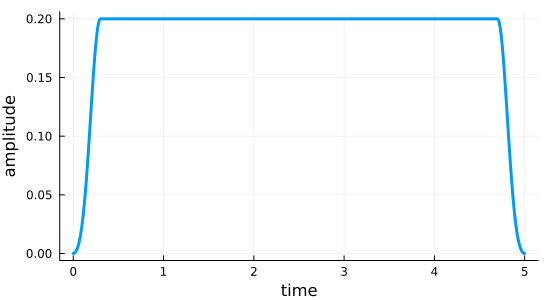

In [9]:
fig = plot_control(ϵ, tlist)

## Optimization target

First, we define a convenience function for the eigenstates.

In [10]:
function ket(label)
    result = Dict("0" => Vector{ComplexF64}([1, 0]), "1" => Vector{ComplexF64}([0, 1]))
    return result[string(label)]
end;

The physical objective of our optimization is to transform the initial state $\ket{0}$ into the target state $\ket{1}$ under the time evolution induced by the Hamiltonian $\op{H}(t)$.

In [11]:
objectives = [Objective(initial_state=ket(0), generator=H, target_state=ket(1))];

The full control problem includes this objective, information about the time grid for the dynamics, and the functional to be used (the square modulus of the overlap $\tau$ with the target state in this case).

In [12]:
using QuantumControl.Functionals: J_T_sm

problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    pulse_options=Dict(),
    iter_stop=500,
    J_T=J_T_sm,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end,
);

## Simulate dynamics under the guess field

Before running the optimization procedure, we first simulate the dynamics under the guess field $\epsilon_{0}(t)$. The following solves equation of motion for the defined objective, which contains the initial state $\ket{\Psi_{\init}}$ and the Hamiltonian $\op{H}(t)$ defining its evolution.

In [13]:
guess_dynamics = propagate_objective(
    objectives[1],
    problem.tlist;
    storage=true,
    observables=(Ψ -> abs.(Ψ) .^ 2,)
)

2×500 Matrix{Float64}:
 1.0  1.0          1.0          1.0          …  0.951457   0.951459  0.951459
 0.0  7.73456e-40  2.03206e-11  2.96638e-10     0.0485427  0.048541  0.048541

In [14]:
function plot_population(pop0::Vector, pop1::Vector, tlist)
    fig = plot(tlist, pop0, label="0", xlabel="time", ylabel="population")
    plot!(fig, tlist, pop1; label="1")
end;

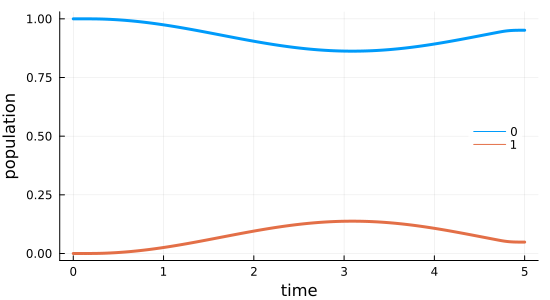

In [15]:
fig = plot_population(guess_dynamics[1, :], guess_dynamics[2, :], tlist)

## Optimization with LBFGSB

In the following we optimize the guess field $\epsilon_{0}(t)$ such that the intended state-to-state transfer $\ket{\Psi_{\init}} \rightarrow \ket{\Psi_{\tgt}}$ is solved.

The GRAPE package performs the optimization by calculating the gradient of $J_T$ with respect to the values of the control field at each point in time. This gradient is then fed into a backend solver that calculates an appropriate update based on that gradient.

By default, this backend is [LBFGSB.jl](https://github.com/Gnimuc/LBFGSB.jl), a wrapper around the true and tested [L-BFGS-B Fortran library](http://users.iems.northwestern.edu/%7Enocedal/lbfgsb.html). L-BFGS-B is a pseudo-Hessian method: it efficiently estimates the second-order Hessian from the gradient information. The search direction determined from that Hessian dramatically improves convergence compared to using the gradient directly as a search direction. The L-BFGS-B method performs its own linesearch to determine how far to go in the search direction.

It can be quite instructive to see how the improvement in the pseudo-Hessian search direction compares to the gradient, how the linesearch finds an appropriate step width. For this purpose, we have a [GRAPELinesearchAnalysis](https://github.com/JuliaQuantumControl/GRAPELinesearchAnalysis.jl) package that automatically generates plots in every iteration of the optimization showing the linesearch behavior

In [16]:
using GRAPELinesearchAnalysis

We feed this into the optimization as part of the `info_hook`.

In [17]:
opt_result_LBFGSB = @optimize_or_load(
    datadir("TLS", "opt_result_LBFGSB.jld2"),
    problem,
    method = :grape,
    force = true,
    info_hook = chain_infohooks(
        GRAPELinesearchAnalysis.plot_linesearch(datadir("TLS", "Linesearch", "LBFGSB")),
        QuantumControl.GRAPE.print_table,
    )
);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   9.51e-01   5.40e-02        n/a    1(0)     6.6
     1   4.45e-02   6.57e-02  -9.07e-01    4(0)     1.4
     2   1.89e-02   4.38e-02  -2.56e-02    3(0)     5.2
     3   5.75e-03   2.33e-02  -1.31e-02    1(0)     1.5
     4   1.03e-05   1.04e-03  -5.74e-03    1(0)     1.4


When going through this tutorial locally, the [generated images for the linesearch](https://github.com/JuliaQuantumControl/GRAPE.jl/tree/data-dump/TLS/Linesearch/LBFGSB) can be found in `docs/TLS/Linesearch/LBFGSB`.

In [18]:
datadir("TLS", "Linesearch", "LBFGSB")

"/home/runner/work/GRAPE.jl/GRAPE.jl/docs/data/TLS/Linesearch/LBFGSB"

In [19]:
opt_result_LBFGSB

GRAPE Optimization Result
-------------------------
- Started at 2022-11-18T05:41:09.765
- Number of objectives: 1
- Number of iterations: 4
- Number of pure func evals: 0
- Number of func/grad evals: 10
- Value of functional: 1.02765e-05
- Reason for termination: J_T < 10⁻³
- Ended at 2022-11-18T05:41:27.270 (17 seconds, 505 milliseconds)


We can plot the optimized field:

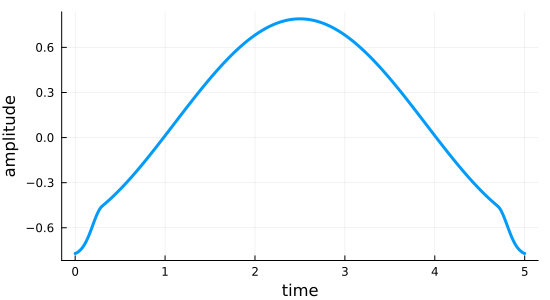

In [20]:
fig = plot_control(opt_result_LBFGSB.optimized_controls[1], tlist)

## Optimization via semi-automatic differentiation

Our GRAPE implementation includes the analytic gradient of the optimization functional `J_T_sm`. Thus, we only had to pass the functional itself to the optimization. More generally, for functionals where the analytic gradient is not known, semi-automatic differentiation can be used to determine it automatically. For illustration, we may re-run the optimization forgoing the known analytic gradient and instead using an automatically determined gradient.

As shown in Goerz et al., arXiv:2205.15044, by evaluating the gradient of $J_T$ via a chain rule in the propagated states, the dependency of the gradient on the final time functional is pushed into the boundary condition for the backward propagation, $|χ_k⟩ = -∂J_T/∂⟨ϕ_k|$. For functionals that can be written in terms of the overlaps $τ_k$ of the forward-propagated states and target states, such as the `J_T_sm` used here, a further chain rule leaves derivatives of `J_T` with respect to the overlaps $τ_k$, which are easily obtained via automatic differentiation. This happens automatically if we use `make_chi` with `force_zygote=true` and pass the resulting `chi` to the optimization:

In [21]:
using QuantumControl.Functionals: make_chi

chi_sm = make_chi(J_T_sm, objectives; force_zygote=true)

opt_result_LBFGSB_via_χ = optimize(problem; method=:grape, chi=chi_sm);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   9.51e-01   5.40e-02        n/a    1(0)    40.3
     1   4.45e-02   6.57e-02  -9.07e-01    4(0)     0.1
     2   1.89e-02   4.38e-02  -2.56e-02    3(0)     0.1
     3   5.75e-03   2.33e-02  -1.31e-02    1(0)     0.0
     4   1.03e-05   1.04e-03  -5.74e-03    1(0)     0.0


In [22]:
opt_result_LBFGSB_via_χ

GRAPE Optimization Result
-------------------------
- Started at 2022-11-18T05:41:31.981
- Number of objectives: 1
- Number of iterations: 4
- Number of pure func evals: 0
- Number of func/grad evals: 10
- Value of functional: 1.02765e-05
- Reason for termination: J_T < 10⁻³
- Ended at 2022-11-18T05:42:12.511 (40 seconds, 530 milliseconds)


## Optimization with Optim.jl

As an alternative to the default L-BFGS-B backend, we can also use any of the gradient-based optimizers in [Optiml.jl](https://github.com/JuliaNLSolvers/Optim.jl). This also gives full control over the linesearch method.

In [23]:
using Optim
using LineSearches

Here, we use the LBFGS implementation that is part of Optim (which is not exactly the same as L-BFGS-B; "B" being the variant of LBFGS with optional additional bounds on the control) with a Hager-Zhang linesearch

In [24]:
opt_result_OptimLBFGS = @optimize_or_load(
    datadir("TLS", "opt_result_OptimLBFGS.jld2"),
    problem,
    method = :grape,
    info_hook = chain_infohooks(
        GRAPELinesearchAnalysis.plot_linesearch(datadir("TLS", "Linesearch", "OptimLBFGS")),
        QuantumControl.GRAPE.print_table,
    ),
    optimizer = Optim.LBFGS(;
        alphaguess=LineSearches.InitialStatic(alpha=0.2),
        linesearch=LineSearches.HagerZhang(alphamax=2.0)
    )
);

In [25]:
opt_result_OptimLBFGS

GRAPE Optimization Result
-------------------------
- Started at 2022-02-14T22:16:10.749
- Number of objectives: 1
- Number of iterations: 27
- Number of pure func evals: 0
- Number of func/grad evals: 80
- Value of functional: 2.49647e-05
- Reason for termination: J_T < 10⁻³
- Ended at 2022-02-14T22:16:43.755 (33 seconds, 6 milliseconds)


We can plot the optimized field:

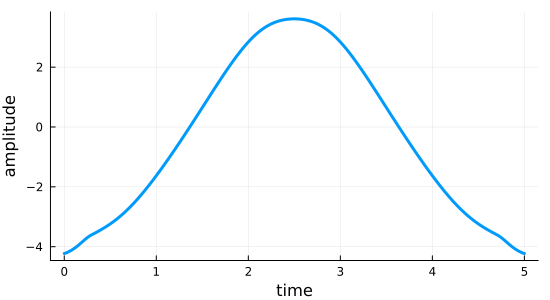

In [26]:
fig = plot_control(opt_result_OptimLBFGS.optimized_controls[1], tlist)

We can see that the choice of linesearch parameters in particular strongly influence the convergence and the resulting field. Play around with different methods and parameters, and compare the different [plots generated by `GRAPELinesearchAnalysis`](https://github.com/JuliaQuantumControl/GRAPE.jl/tree/data-dump/TLS/Linesearch/OptimLBFGS)!

Empirically, we find the default L-BFGS-B to have a very well-behaved linesearch.

## Simulate the dynamics under the optimized field

Having obtained the optimized control field, we can simulate the dynamics to verify that the optimized field indeed drives the initial state $\ket{\Psi_{\init}} = \ket{0}$ to the desired target state $\ket{\Psi_{\tgt}} = \ket{1}$.

In [27]:
using QuantumControl.Controls: substitute

opt_dynamics = propagate_objective(
    substitute(objectives[1], IdDict(ϵ => opt_result_LBFGSB.optimized_controls[1])),
    problem.tlist;
    storage=true,
    observables=(Ψ -> abs.(Ψ) .^ 2,)
)

2×500 Matrix{Float64}:
 1.0  0.99994     0.999762     …  0.000199992  4.61252e-5  1.02765e-5
 0.0  5.96912e-5  0.000237727     0.9998       0.999954    0.99999

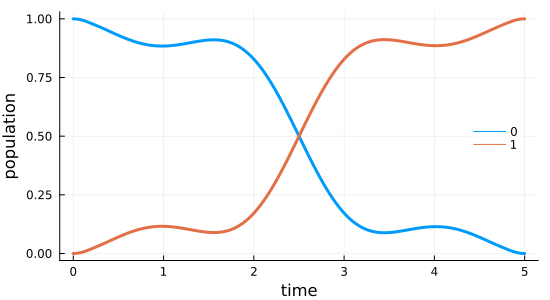

In [28]:
fig = plot_population(opt_dynamics[1, :], opt_dynamics[2, :], tlist)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*